In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import kaleido
import plotly.io as pio
import scipy.stats as stats
import tensorflow as tf

In [2]:
plot_folder = '/Users/eddie/cs163/src/Plots'
data_folder = '/Users/eddie/cs163/src/Data'
pio.renderers.default = 'png'

In [3]:
df = pd.read_csv('/Users/eddie/cs163/src/Data/final.csv', index_col=['Timeframe'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 2024-08-01 to 2005-01-01
Data columns (total 18 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Food and Beverages CPI (target)                  236 non-null    float64
 7   Civilian workers Total compensation              234 non-null    float64
 8   Private industry workers Total compensation      234 non-null    float64
 9   State and government 

In [4]:
Y = df.iloc[:, 6]
X = df[[c for c in df.columns if c not in ['Food and Beverages CPI (target)']]]

### KNN Imputation for Fish Food and Horticulture

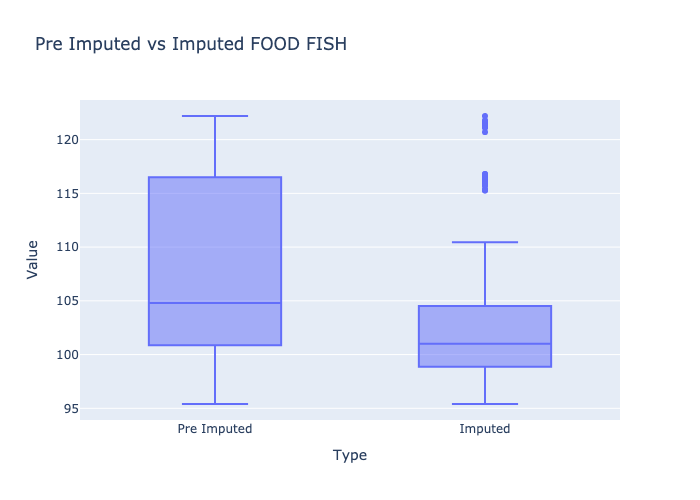

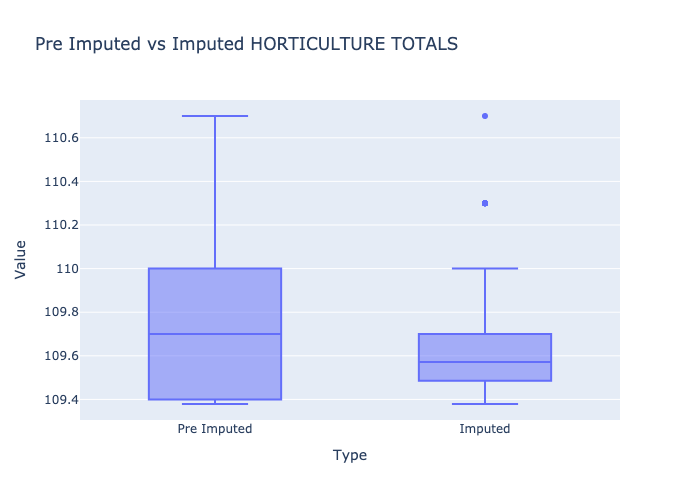

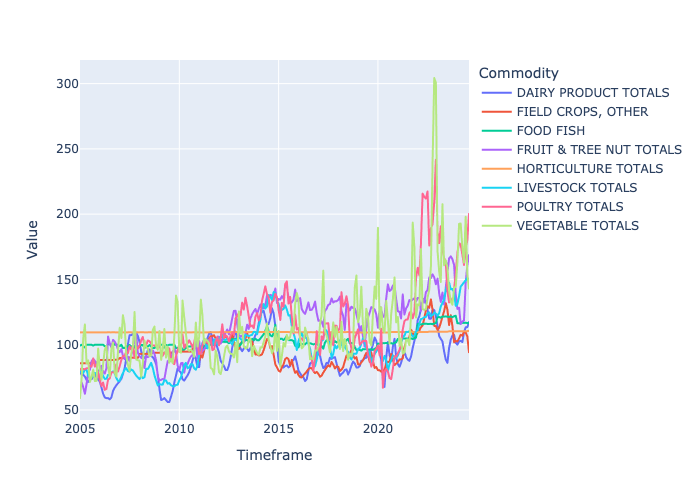

In [5]:
imputer = KNNImputer(n_neighbors=7)
# scaler = StandardScaler()
RPI_df = X.iloc[:,9:]
# RPI_df = pd.DataFrame(scaler.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)
RPI_df_imputed = pd.DataFrame(imputer.fit_transform(RPI_df), columns=RPI_df.columns, index=X.index)

for column in ['FOOD FISH', 'HORTICULTURE TOTALS']:
    data = pd.DataFrame({
        'Pre Imputed': RPI_df[column], 
        'Imputed': RPI_df_imputed[column]
    }, index=X.index)
    data_melted = data.melt(var_name='Type', value_name='Value', ignore_index=False)
    fig = px.box(data_melted, title='Pre Imputed vs Imputed ' + column, x = 'Type', y = 'Value')
    fig.write_image(os.path.join(plot_folder,'KNN_Imputed_boxplot_for_' + column + '.png'), width=1280, height=640)
    fig.show()
    
RPI_df_imputed_melted = RPI_df_imputed.melt(value_name='Value', var_name='Commodity', ignore_index=False)
# RPI_df_imputed_melted = RPI_df_imputed_melted[RPI_df_imputed_melted['Commodity'].isin(['FOOD FISH', 'HORTICULTURE TOTALS'])]
fig = px.line(RPI_df_imputed_melted, x=RPI_df_imputed_melted.index, y='Value', color='Commodity')
fig.write_image(os.path.join(plot_folder,'Imputed_RPI_timeseries.png'), width=1280, height=640)
fig.show()

After the imputation, the data for FOOD FISH and HORTICULTURE appear to maintain the normal distribution but have new outliers. However, based on the timeseries line plot with other commodities RPI, the outliers are reasonable because other indices also have strong outliers at these periods. So, we can use the imputed data for further analysis.

In [6]:
# Update newly imputed values
X.update(RPI_df_imputed)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 2024-08-01 to 2005-01-01
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Civilian workers Total compensation              234 non-null    float64
 7   Private industry workers Total compensation      234 non-null    float64
 8   State and government workers Total compensation  234 non-null    float64
 9   DAIRY PRODUCT TOTALS 

#### Consumer Expenditures Imputation

Since CE data is 2 months behind others, we will also use KNN Imputation to fill the missing value for them. Notes that this is only 2/236 so it should not affect the distribution.

In [7]:
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 236 entries, 2024-08-01 to 2005-01-01
Data columns (total 17 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Frozen Food Manufacturing PPI                    236 non-null    float64
 1   Dried and dehydrated Food Manufacturing PPI      236 non-null    float64
 2   Seafood Production and Packaging PPI             236 non-null    float64
 3   Snack Food Manufacturing PPI                     236 non-null    float64
 4   Perishable Food Manufacturing PPI                236 non-null    float64
 5   Food and Beverages Retailers PPI                 236 non-null    float64
 6   Civilian workers Total compensation              236 non-null    float64
 7   Private industry workers Total compensation      236 non-null    float64
 8   State and government workers Total compensation  236 non-null    float64
 9   DAIRY PRODUCT TOTALS 

## Effect to CPI by RPI Commodity/ CE Worker segment/ PPI Industry using ARIMA with eXogenous variables (ARIMAX)

In [8]:
RPI_df = X.iloc[:, 9:].copy()
CE_df = X.iloc[:, 6:9].copy()
PPI_df = X.iloc[:, :6].copy()
category = [RPI_df, CE_df, PPI_df]

### Assumption check

#### Stationary of CPI

As we saw in the EDA time series plot of CPI, it is not stationary. So, we will use differencing and use Augmented Dick-Fuller test to determine the level of differencing needed for ARIMAX. Let the threshold be 0.05, our null hypothesis is the time-series has a unit root, which is non-stationary. 

In [9]:
adf_test = adfuller(Y)
print(f'ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

ADF Statistic: -2.126893677201998, p-value: 0.2338389062245415


Originally, p-value is 0.234 > 0.05. So, we cannot reject the null hypothesis yet and transformation is needed. We will try differencing 1 time.

In [10]:
def differencing(X, d):
    X_new = X.values
    for i in range(d):
        X_tmp = np.array(np.zeros(len(X)))
        for index in range(1, len(X)):
            X_tmp[index] = X_new[index] - X_new[index - 1]
        X_new = X_tmp
    
    return pd.Series(X_new, index=X.index)

for d in range(4):
    adf_test = adfuller(differencing(Y, d))
    print(f'Differencing level {d}: ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}')

Differencing level 0: ADF Statistic: -2.126893677201998, p-value: 0.2338389062245415
Differencing level 1: ADF Statistic: -3.118579173349528, p-value: 0.025208451371145114
Differencing level 2: ADF Statistic: -12.552950659836824, p-value: 2.1855447918059752e-23
Differencing level 3: ADF Statistic: -7.575930407533805, p-value: 2.7618024415878363e-11


So with 1 time differencing, CPI time-series is already stationary, so we will go with ``d = 1``

### AR order and MA order

We will perform ACF and PACF to determine the Autoregressive term and Moving Average term.

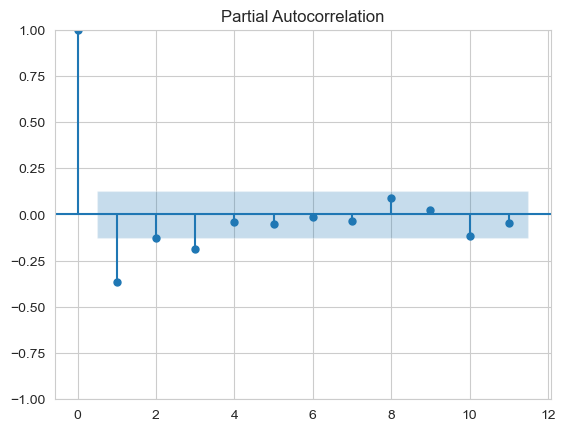

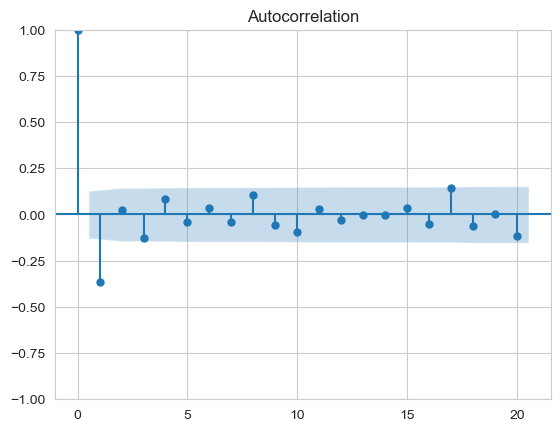

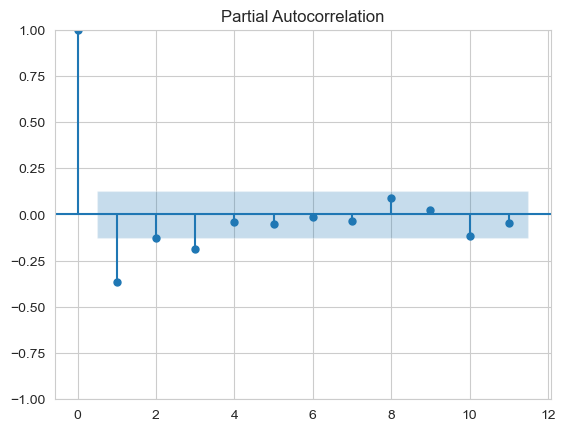

In [11]:
plot_acf(differencing(Y,2), lags=20)
plot_pacf(differencing(Y,2), lags=11)

So MA term should be 9 and AR term should be 5

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency -1MS will be used.

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency -1MS will be used.

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.86103D-01    |proj g|=  6.14625D+00

At iterate    5    f=  6.15185D-01    |proj g|=  1.64650D+00

At iterate   10    f=  5.92992D-01    |proj g|=  4.47471D-01

At iterate   15    f=  5.89294D-01    |proj g|=  1.66512D-01

At iterate   20    f=  5.88398D-01    |proj g|=  5.51970D-02

At iterate   25    f=  5.87773D-01    |proj g|=  4.56285D-01

At iterate   30    f=  5.86726D-01    |proj g|=  3.23693D-02

At iterate   35    f=  5.86705D-01    |proj g|=  3.44309D-02

At iterate   40    f=  5.86680D-01    |proj g|=  5.72748D-02

At iterate   45    f=  5.86616D-01    |proj g|=  4.81626D-02

At iterate   50    f=  5.86367D-01    |proj g|=  4.92139D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



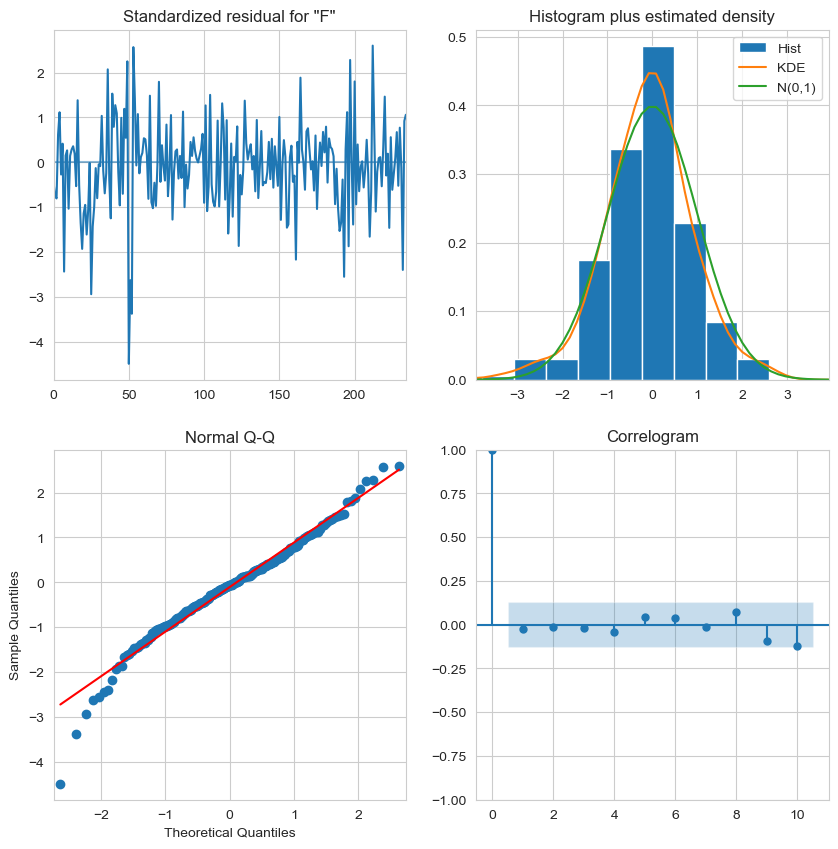

In [12]:
model = SARIMAX(Y, exog=X.iloc[:,9:], order=(2, 1, 3))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,10))
plt.show()

In [13]:
  # Your exogenous variables
dat = X
vif_data = pd.DataFrame()
vif_data['Variable'] = dat.columns
vif_data['VIF'] = [variance_inflation_factor(dat.values, i) for i in range(dat.shape[1])]

print(vif_data)

                                           Variable          VIF
0                     Frozen Food Manufacturing PPI  3464.796387
1       Dried and dehydrated Food Manufacturing PPI  3990.056876
2              Seafood Production and Packaging PPI  2811.256153
3                      Snack Food Manufacturing PPI  3180.623279
4                 Perishable Food Manufacturing PPI  2161.688172
5                  Food and Beverages Retailers PPI  3653.764984
6               Civilian workers Total compensation  4728.773460
7       Private industry workers Total compensation  3237.993766
8   State and government workers Total compensation   242.468793
9                              DAIRY PRODUCT TOTALS    90.031530
10                               FIELD CROPS, OTHER   362.524561
11                                        FOOD FISH  2805.681759
12                          FRUIT & TREE NUT TOTALS   172.357959
13                              HORTICULTURE TOTALS  2251.396776
14                       

### Random Forest 


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
# model = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=10)
model = RandomForestRegressor()
model = model.fit(X_train, y_train)

y_predicted = model.predict(X_test)
# Evaluation metrics
mae = mean_absolute_error(y_test, y_predicted)
mse = mean_squared_error(y_test, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predicted)

# Display results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Mean Absolute Error (MAE): 0.6806906250000028
Mean Squared Error (MSE): 0.7937110445521093
Root Mean Squared Error (RMSE): 0.8909046214674774
R-squared (R²): 0.9994808253220536


### LSTM Approach

In [131]:
import datetime as dt

X_tmp = X.reset_index()

# X_tmp["Year"] = X_tmp['Timeframe'].apply(lambda x: x.dt.year)
X_tmp['Timeframe'] = pd.to_datetime(X_tmp['Timeframe'], errors='coerce')
X_tmp['Year'] = X_tmp['Timeframe'].dt.year
X_tmp['Month'] = X_tmp['Timeframe'].dt.month
X_tmp.drop(columns=['Timeframe'], inplace=True)
scaler = MinMaxScaler()

def create_sequences(data, target, seq_length):
    data_scaled = scaler.fit_transform(data)
    # target = scaler.fit_transform(target)
    X = []
    y = []
    
    for i in range(len(data_scaled) - seq_length):
        # Collect sequences across all features (except target) for each time step
        X.append(data_scaled[i:i+seq_length, :-1]) # All columns except the last one for X
        y.append(target[i+seq_length]) # Target value from the last column at each sequence end
    
    return np.array(X), np.array(y)

sequenced_X, sequenced_y = create_sequences(X_tmp, Y, 24) 


# sequenced_X = scaler.fit_transform(sequenced_X)
# for dim in sequenced_X:
#     sequenced_X[dim] = scaler.fit_transform(sequenced_X[dim])
sequenced_X.shape

/tmp/ipykernel_18944/4012511901.py:21: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



(212, 24, 18)

In [137]:
X_train, X_test, y_train, y_test = train_test_split(sequenced_X, sequenced_y, test_size=0.2, random_state=42, shuffle=False)

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    
    tf.keras.layers.LSTM(units=64, return_sequences=False),
    
    # tf.keras.layers.LSTM(units=32, return_sequences=False),

    
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/eddie/miniconda3/envs/cs163/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_53 (LSTM)                  │ (None, 24, 128)        │        75,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,897 (503.50 KB)

 Trainable params: 128,897 (503.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 60892.4023
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 59353.7539
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 57869.1797
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 57655.9297
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 55859.2305
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 54353.5898
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 52847.5586
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 52603.0234
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 50131.2734
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 49219.6680
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 46872.3281
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45751.2031
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 44246.2773
Epoch 14/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 41442.4102
Epoch 15/200
6/6 ━━━━━━━━━━━━

KeyError: 'val_loss'

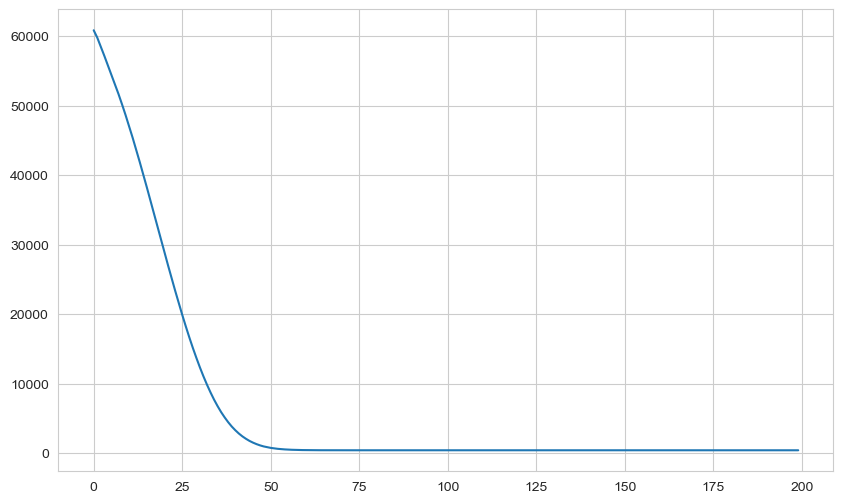

In [138]:
history = model.fit(X_train, y_train, epochs=200)

y_predicted = model.predict(X_test)

mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test, y_predicted)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_predicted)

# Display additional results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.show()